<a href="https://colab.research.google.com/github/ayshaasif/MachineLearning/blob/main/real_vs_fake_deepfake_detection_2_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayshaasif","key":"0ff33bccae646ffd4db7f9394335a985"}'}

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets list

ref                                                        title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide       Covid Cases and Deaths WorldWide              8KB  2023-02-01 12:22:51          10605        349  1.0              
datascientistanna/customers-dataset                        Shop Customer Data                           23KB  2023-02-07 18:42:21           9032        207  1.0              
justin2028/unemployment-in-america-per-us-state            Unemployment in America, Per US State       826KB  2023-03-02 07:26:03            905         46  1.0              
anas123siddiqui/mobiles                                    Mobiles                                      59KB  2023-02-18 16:3

In [7]:
!kaggle datasets download -d 'xhlulu/140k-real-and-fake-faces'

100% 3.74G/3.75G [00:44<00:00, 126MB/s] 
100% 3.75G/3.75G [00:44<00:00, 89.9MB/s]


In [8]:
!unzip -q 140k-real-and-fake-faces.zip -d 140k-real-and-fake-faces

In [9]:
import itertools 
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import load_model, Sequential

In [10]:
df = pd.read_csv("/content/140k-real-and-fake-faces/train.csv")

In [11]:
df.shape

(100000, 6)

In [12]:
df.head()

,Unnamed: 0,original_path,id,label,label_str,path
0,0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,31355,1,real,train/real/31355.jpg
1,1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,02884,1,real,train/real/02884.jpg
2,2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,33988,1,real,train/real/33988.jpg
3,3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,53875,1,real,train/real/53875.jpg
4,4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,24149,1,real,train/real/24149.jpg


In [13]:
import json
import sklearn
import cv2
import seaborn as sns
import sys
import pandas as pd
from pprint import pprint
from collections import defaultdict
import gc
import os
import pathlib
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
# from openslide import OpenSlide
from PIL import Image
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.layers import (Dense, Flatten, Dropout)
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings(action='ignore')

In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [15]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [17]:
import cv2
import imghdr

In [18]:
# data_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train'

In [19]:
# os.listdir(data_dir)

In [20]:
image_exts = ['jpeg','jpg','png','bmp']

In [ ]:
# os.listdir(os.path.join(data_dir,image_class))[0:10]

In [ ]:
# for image_class in os.listdir(data_dir):
#     for image in os.listdir(os.path.join(data_dir,image_class))[0:8000]:
#         image_path = os.path.join(data_dir,image_class,image)
#         try:
#             img = cv2.imread(image_path)
#             tip = imghdr.what(image_path)
#             if tip not in image_exts:
#                 print('Image notin ext list {}'.format(image_path))
#                 os.remove(image_path)
#         except Exception as e:
#             print("Issue with image {}".format(image_path))

In [21]:
img = cv2.imread('/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/real/00000.jpg')

In [22]:
img.shape

(256, 256, 3)

In [23]:
type(img)

numpy.ndarray

In [24]:
img

array([[[146, 131,   4],
        [140, 125,   0],
        [146, 129,   2],
        ...,
        [155, 119,   1],
        [151, 116,   0],
        [152, 117,   0]],

       [[145, 130,   3],
        [141, 126,   0],
        [145, 128,   1],
        ...,
        [152, 115,   0],
        [149, 114,   0],
        [151, 116,   0]],

       [[148, 131,   4],
        [145, 128,   1],
        [144, 127,   0],
        ...,
        [151, 114,   0],
        [149, 112,   0],
        [150, 113,   0]],

       ...,

       [[168, 153,  21],
        [170, 155,  23],
        [171, 156,  24],
        ...,
        [160, 155, 130],
        [159, 155, 131],
        [160, 156, 132]],

       [[166, 148,  17],
        [167, 149,  18],
        [168, 150,  19],
        ...,
        [164, 160, 136],
        [164, 159, 138],
        [163, 158, 137]],

       [[165, 147,  16],
        [166, 148,  17],
        [167, 149,  18],
        ...,
        [159, 155, 131],
        [161, 156, 135],
        [161, 156, 135]]

In [25]:
data_valid_dir = '/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train'

In [26]:
len(os.listdir(os.path.join(data_valid_dir,'fake')))

50000

In [28]:
for image_class in os.listdir(data_valid_dir):
    for image in os.listdir(os.path.join(data_valid_dir,image_class)):
        image_path = os.path.join(data_valid_dir,image_class,image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image notin ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}".format(image_path))

# **Load Data**

In [29]:
# tf.data.Dataset??

In [30]:
# tf.data.Dataset.list_files??

In [31]:
# tf.keras.utils.image_dataset_from_directory??

In [34]:
data = tf.keras.utils.image_dataset_from_directory('/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train')

Found 100000 files belonging to 2 classes.


In [35]:
data

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [36]:
data_iterator =  data.as_numpy_iterator()

In [37]:
batch = data_iterator.next()

In [38]:
len(batch) #images and labels

2

In [39]:
batch[0].shape #(batch size, image-h,image-w,channels) image as numpy arrays

(32, 256, 256, 3)

In [40]:
batch[1] #labels -> fake 0 and real 1

array([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0], dtype=int32)

 will return a `tf.data.Dataset` that yields batches of images from
  the subdirectories `class_a` and `class_b`, together with labels
  0 and 1 (0 corresponding to `class_a` and 1 corresponding to `class_b`).

In [41]:
batch[0][0],batch[1][0]

(array([[[211., 213., 212.],
         [211., 213., 212.],
         [211., 213., 212.],
         ...,
         [215., 222., 228.],
         [215., 224., 229.],
         [214., 223., 228.]],
 
        [[211., 213., 212.],
         [211., 213., 212.],
         [211., 213., 212.],
         ...,
         [214., 221., 227.],
         [213., 222., 227.],
         [212., 221., 226.]],
 
        [[211., 213., 212.],
         [211., 213., 212.],
         [211., 213., 212.],
         ...,
         [211., 218., 224.],
         [210., 219., 224.],
         [210., 219., 224.]],
 
        ...,
 
        [[ 40.,  38.,  39.],
         [ 38.,  36.,  37.],
         [ 34.,  32.,  33.],
         ...,
         [185., 203., 213.],
         [178., 198., 209.],
         [176., 196., 207.]],
 
        [[ 33.,  31.,  32.],
         [ 32.,  30.,  31.],
         [ 32.,  30.,  31.],
         ...,
         [184., 202., 212.],
         [176., 196., 207.],
         [176., 196., 207.]],
 
        [[ 34.,  32.,  33.],
 

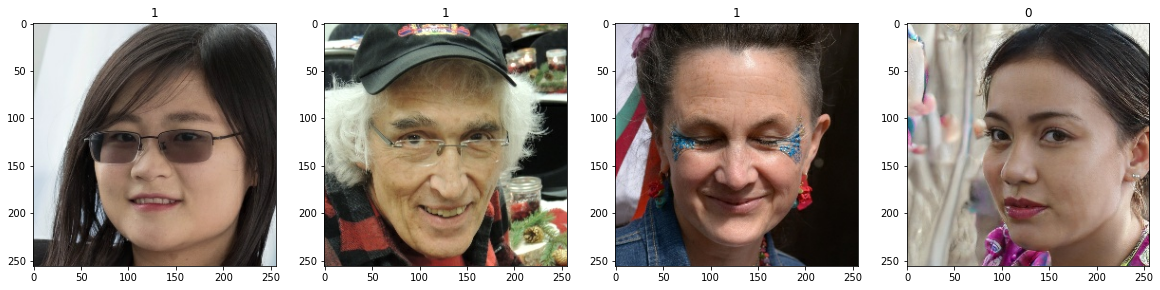

In [42]:
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [43]:
nxt_batch = data_iterator.next()

In [44]:
len(nxt_batch[1])

32

In [45]:
nxt_batch[1][13:18]

array([1, 1, 1, 0, 0], dtype=int32)

In [46]:
nxt_batch[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1], dtype=int32)

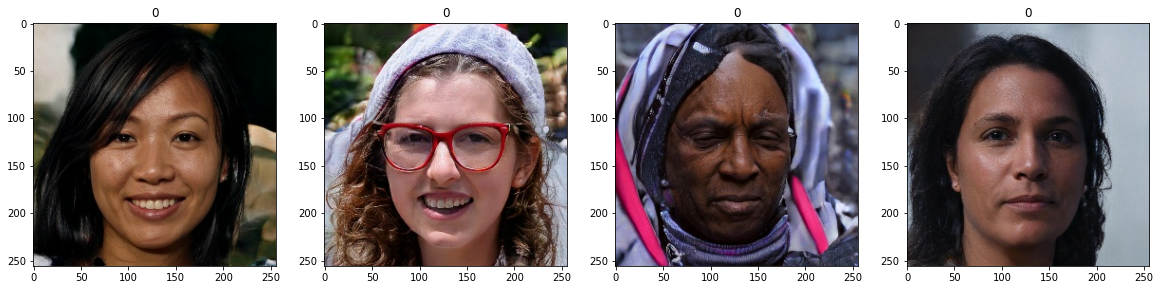

In [47]:
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(nxt_batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(nxt_batch[1][idx])

# **Preprocessing Data**

In [53]:
data = tf.keras.utils.image_dataset_from_directory('/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train')

Found 100000 files belonging to 2 classes.


In [54]:
data = data.map(lambda x,y:(x/255,y))

In [55]:
data

<MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [56]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

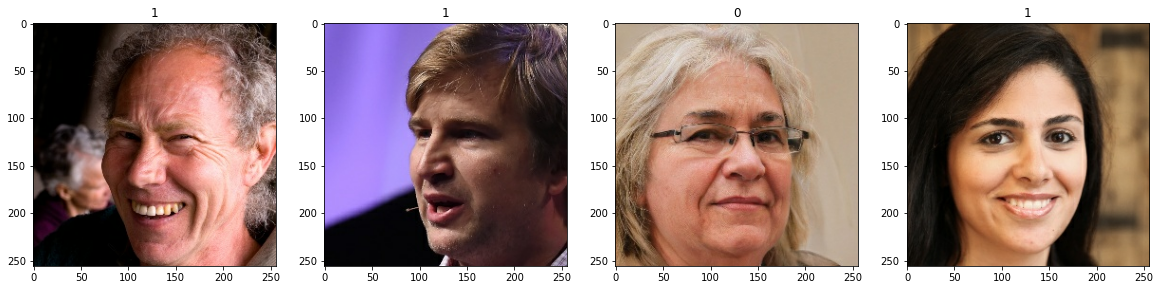

In [57]:
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# ***Split Data***

In [58]:
len(data)

3125

3125 batches , each batch containes 32 images,label

In [60]:
3125*32

100000

In [61]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [62]:
train_size,val_size,test_size

(2187, 625, 313)

In [63]:
train_size + val_size +test_size

3125

In [64]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

 ***Note : dataset is already shuffled***

In [65]:
len(test)

313

# **Deep Model**

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense,Flatten,Dropout

In [67]:
# Conv2D??

In [68]:
model = Sequential()

In [69]:
model.add(Conv2D(filters=16,kernel_size = (3,3),strides =  1, activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())


model.add(Conv2D(filters=32,kernel_size = (3,3),strides =  1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=16,kernel_size = (3,3),strides =  1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [70]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [ ]:
len(train)

437

In [71]:
model.compile(loss=tf.losses.BinaryCrossentropy(),
                          optimizer = tf.keras.optimizers.Adam(),
                          metrics=['accuracy'])

* ***Train the model***

In [78]:
!mkdir logs

In [80]:
logdir='logs'

In [81]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [72]:
hist = model.fit(train,validation_data=val,verbose=1)

2187/2187 [==============================] - 293s 128ms/step - loss: 0.5131 - accuracy: 0.7405 - val_loss: 0.3846 - val_accuracy: 0.8308


In [74]:
model2 = Sequential()

In [75]:
model2.add(Conv2D(filters=16,kernel_size = (3,3),strides =  1, activation='relu',input_shape=(256,256,3)))
model2.add(MaxPooling2D())


model2.add(Conv2D(filters=32,kernel_size = (3,3),strides =  1, activation='relu'))
model2.add(MaxPooling2D())

model2.add(Conv2D(filters=16,kernel_size = (3,3),strides =  1, activation='relu'))
model2.add(MaxPooling2D())

model2.add(Flatten())

model2.add(Dense(256,activation='relu'))
model2.add(Dense(1,activation='sigmoid'))

In [83]:
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                          optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                          metrics=['accuracy'])

In [84]:
hist_2 = model2.fit(train,epochs=5,validation_data=val,verbose=1,callbacks=[tensorboard_callback])

Epoch 1/5
2187/2187 [==============================] - 247s 112ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 2/5
2187/2187 [==============================] - 188s 86ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.5009
Epoch 3/5
2187/2187 [==============================] - 185s 85ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.5013
Epoch 4/5
2187/2187 [==============================] - 242s 111ms/step - loss: 0.6932 - accuracy: 0.5012 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 5/5
2187/2187 [==============================] - 249s 114ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6931 - val_accuracy: 0.5015


Text(0, 0.5, 'accuracy')

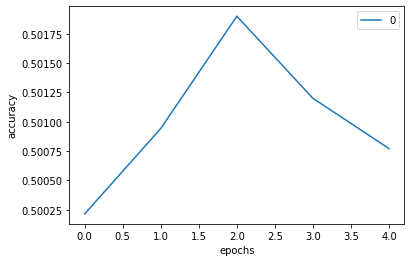

In [85]:
pd.DataFrame(hist_2.history['accuracy']).plot()
plt.xlabel('epochs')
plt.ylabel('accuracy')


In [87]:
hist_2.history

{'loss': [0.6931690573692322,
  0.6931682229042053,
  0.6931668519973755,
  0.6931673288345337,
  0.693171501159668],
 'accuracy': [0.5002143383026123,
  0.5009430646896362,
  0.5019004344940186,
  0.501200258731842,
  0.5007715821266174],
 'val_loss': [0.6931474804878235,
  0.6931524872779846,
  0.6931504607200623,
  0.6931462287902832,
  0.6931442022323608],
 'val_accuracy': [0.5015000104904175,
  0.5008999705314636,
  0.5012999773025513,
  0.5014500021934509,
  0.5015000104904175]}



```
model2.add(Conv2D(filters=16,kernel_size = (3,3),strides =  1, activation='relu',input_shape=(256,256,3)))
model2.add(MaxPooling2D())
```



In [88]:
model_3 = Sequential()
model_3.add(Conv2D(filters=16,kernel_size=(3,3), strides=1,activation='relu',input_shape=(256,256)))
model_3.add(Conv2D(filters=16,kernel_size=(3,3), strides=1,activation='relu'))


In [ ]:
model_3.compile(loss=tf.losses.BinaryCrossentropy(),
                          optimizer = tf.keras.optimizers.Adam(),
                          metrics=['accuracy'])